# Create ICESat-2 GDF prior to masking
Copied code from Plot_ATL08 to streamline without deleting anything

In [ ]:
#!pip install earthpy

In [1]:
# Import necessary packages
import os
import rasterio
from rasterio.enums import Resampling
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns
from rasterstats import zonal_stats
import statistics
import scipy.stats as stats
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
import rioxarray as riox
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent
from rasterio import features

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

%matplotlib inline

In [2]:
#set working directory?
os.chdir(os.path.join(et.io.HOME, 
                      'ICESat-2_Snowdepth'))

In [3]:
dem_path = os.path.join("data",
                       "mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif")
dem_9m_path = os.path.join("data",
                       "mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_9m.tif")

In [78]:
# Change path based on snow-on or snow-off data
ATL08_path = os.path.join("data/ATL08_simplified_snwoff/")

In [79]:
filetype = '*.csv'

files = [f for f in os.listdir(ATL08_path) if f.endswith(filetype[1:])]

In [80]:
files

['ATL08_20201006_gt3l.csv',
 'ATL08_20201006_gt2r.csv',
 'ATL08_20201011_gt2l.csv',
 'ATL08_20201011_gt2r.csv',
 'ATL08_20201006_gt1l.csv',
 'ATL08_20200908_gt1l.csv',
 'ATL08_20201011_gt1l.csv',
 'ATL08_20201011_gt3l.csv',
 'ATL08_20200810_gt1r.csv',
 'ATL08_20200805_gt3r.csv',
 'ATL08_20201011_gt1r.csv',
 'ATL08_20200810_gt2r.csv',
 'ATL08_20200805_gt3l.csv',
 'ATL08_20201006_gt2l.csv',
 'ATL08_20200810_gt1l.csv',
 'ATL08_20200810_gt3r.csv',
 'ATL08_20201011_gt3r.csv',
 'ATL08_20201006_gt3r.csv',
 'ATL08_20200805_gt1l.csv',
 'ATL08_20201006_gt1r.csv',
 'ATL08_20200805_gt2r.csv',
 'ATL08_20200805_gt1r.csv',
 'ATL08_20200805_gt2l.csv',
 'ATL08_20200810_gt2l.csv',
 'ATL08_20200810_gt3l.csv']

In [81]:
atlas_tracks = glob.glob(ATL08_path + "/*.csv")
atlas_tracks

['data/ATL08_simplified_snwoff/ATL08_20201006_gt3l.csv',
 'data/ATL08_simplified_snwoff/ATL08_20201006_gt2r.csv',
 'data/ATL08_simplified_snwoff/ATL08_20201011_gt2l.csv',
 'data/ATL08_simplified_snwoff/ATL08_20201011_gt2r.csv',
 'data/ATL08_simplified_snwoff/ATL08_20201006_gt1l.csv',
 'data/ATL08_simplified_snwoff/ATL08_20200908_gt1l.csv',
 'data/ATL08_simplified_snwoff/ATL08_20201011_gt1l.csv',
 'data/ATL08_simplified_snwoff/ATL08_20201011_gt3l.csv',
 'data/ATL08_simplified_snwoff/ATL08_20200810_gt1r.csv',
 'data/ATL08_simplified_snwoff/ATL08_20200805_gt3r.csv',
 'data/ATL08_simplified_snwoff/ATL08_20201011_gt1r.csv',
 'data/ATL08_simplified_snwoff/ATL08_20200810_gt2r.csv',
 'data/ATL08_simplified_snwoff/ATL08_20200805_gt3l.csv',
 'data/ATL08_simplified_snwoff/ATL08_20201006_gt2l.csv',
 'data/ATL08_simplified_snwoff/ATL08_20200810_gt1l.csv',
 'data/ATL08_simplified_snwoff/ATL08_20200810_gt3r.csv',
 'data/ATL08_simplified_snwoff/ATL08_20201011_gt3r.csv',
 'data/ATL08_simplified_snwoff/

In [82]:
track_names = []
for file in files:
    track_names.append(f'{file[15:19]}_{file[6:10]}-{file[10:12]}-{file[12:14]}')

In [83]:
track_names

['gt3l_2020-10-06',
 'gt2r_2020-10-06',
 'gt2l_2020-10-11',
 'gt2r_2020-10-11',
 'gt1l_2020-10-06',
 'gt1l_2020-09-08',
 'gt1l_2020-10-11',
 'gt3l_2020-10-11',
 'gt1r_2020-08-10',
 'gt3r_2020-08-05',
 'gt1r_2020-10-11',
 'gt2r_2020-08-10',
 'gt3l_2020-08-05',
 'gt2l_2020-10-06',
 'gt1l_2020-08-10',
 'gt3r_2020-08-10',
 'gt3r_2020-10-11',
 'gt3r_2020-10-06',
 'gt1l_2020-08-05',
 'gt1r_2020-10-06',
 'gt2r_2020-08-05',
 'gt1r_2020-08-05',
 'gt2l_2020-08-05',
 'gt2l_2020-08-10',
 'gt3l_2020-08-10']

In [84]:
def open_atl08(data_files):
    
    atlas_df = pd.concat((pd.read_csv(f) for f in data_files), keys=track_names)
    atlas_df = atlas_df.reset_index(level=1, drop=True).rename_axis('Track').reset_index()
    atlas_gdf = gpd.GeoDataFrame(atlas_df, crs='epsg:32611', geometry=gpd.points_from_xy(atlas_df.x, atlas_df.y))
    return atlas_gdf

In [87]:
atlas_gdf = open_atl08(atlas_tracks)
atlas_gdf['date'] = atlas_gdf['Track']
atlas_gdf['date'] = atlas_gdf['date'].map(lambda x: x.split('_')[1])
atlas_gdf['Track'] = atlas_gdf['Track'].map(lambda x: x.split('_')[0])
atlas_gdf.head()

,Track,Unnamed: 0,h_te_mean,h_te_median,h_te_min,h_te_max,latitude,longitude,h_te_mode,h_te_skew,n_te_photons,segment_snowcover,terrain_slope,h_te_uncertainty,dem_h,x,y,geometry,date
0,gt3l,0,2451.731934,2451.741455,2451.040039,2452.421387,38.218246,-119.337860,2.451700e+03,-0.117081,9.0,1.0,0.069570,272.414673,2457.634521,295338.472682,4.232614e+06,POINT (295338.473 4232614.348),2020-10-06
1,gt3l,1,2469.254150,2470.706543,2462.485840,2474.258545,38.216446,-119.338066,2.472800e+03,-0.682726,20.0,1.0,0.128141,123.462868,2468.296143,295315.389869,4.232415e+06,POINT (295315.390 4232414.983),2020-10-06
2,gt3l,2,2492.986084,2493.645996,2477.231201,2499.942383,38.215549,-119.338181,2.496700e+03,-1.348986,18.0,1.0,0.253251,138.499619,2477.662109,295302.856888,4.232316e+06,POINT (295302.857 4232315.750),2020-10-06
3,gt3l,3,2507.901123,2503.987061,2501.117920,2524.834717,38.214649,-119.338295,2.504000e+03,0.964010,15.0,1.0,0.287472,167.194092,2492.937012,295290.313016,4.232216e+06,POINT (295290.313 4232216.093),2020-10-06
4,gt3l,4,2544.308838,2538.791260,2530.073242,2563.986816,38.213932,-119.338379,3.402823e+38,0.457140,19.0,1.0,0.349252,133.912354,2512.921631,295280.954354,4.232137e+06,POINT (295280.954 4232136.689),2020-10-06


In [88]:
atlas_gdf.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 120°W to 114°W - by country
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

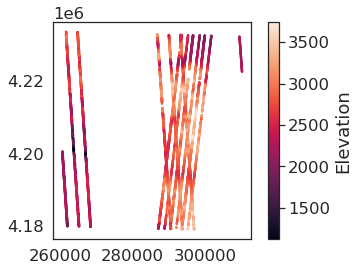

In [89]:
atlas_gdf.plot(column='h_te_median', s=2, legend=True, legend_kwds={'label': "Elevation", 'orientation': "vertical"});

In [90]:
dem_path = os.path.join("data",
                       "mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif")
dem_9m_path = os.path.join("data",
                       "mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_9m.tif")

In [91]:
# Proceess and Open Snow-Off Data
# Open the file using a context manager ("with rio.open" statement)

with rio.open(dem_9m_path) as dem_9m:
    dem_9m_arr = dem_9m.read(1)
    dem_9m_meta = dem_9m.profile
    dem_9m_plot_ext = plotting_extent(dem_9m)
    print(dem_9m.crs)

#Clean raster by removing zero values
dem_9m_arr[dem_9m_arr == (-9999.)] = np.nan
dem_9m_arr[dem_9m_arr == (0.)] = np.nan

print(dem_9m_plot_ext)
xmin_9m,ymin_9m,xmax_9m,ymax_9m = dem_9m.bounds

EPSG:32611
(254247.0, 307338.0, 4179330.0, 4229667.0)


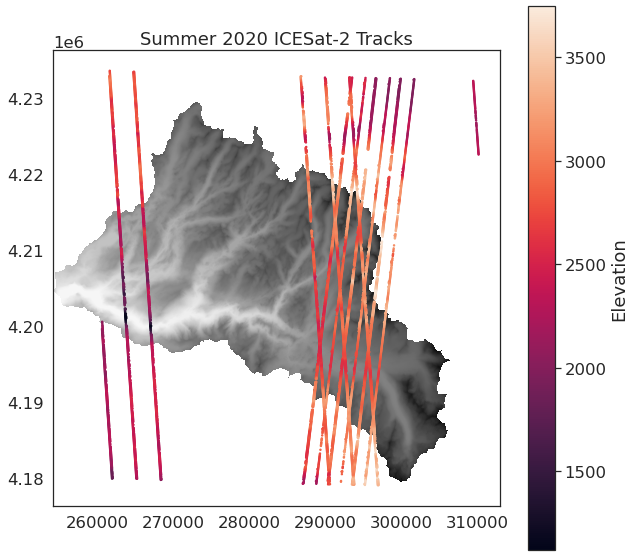

In [92]:
# Change the title based on the season being mapped

f, ax = plt.subplots(figsize = (10,10))
plt.title('Summer 2020 ICESat-2 Tracks')
im = ax.imshow(dem_9m_arr, cmap='Greys', extent=[xmin_9m,xmax_9m,ymin_9m,ymax_9m])
atlas_gdf.plot(column='h_te_median', ax=ax, s=2, legend=True, legend_kwds={'label': "Elevation", 'orientation': "vertical"});

In [93]:
summer_2020_pre = pd.DataFrame(atlas_gdf)
summer_2020_pre.to_csv('summer_2020_pre.csv')